In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
%cd gdrive/MyDrive/Datasets/Parkinson

[Errno 2] No such file or directory: 'gdrive/MyDrive/Datasets/Parkinson'
/content/gdrive/MyDrive/Datasets/Parkinson


# Imports and Parameters

In [ ]:
!pip install visualkeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 4.6 MB/s 


In [ ]:
import visualkeras

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.utils import plot_model
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


In [ ]:
train_path = 'output/train'
test_path = 'output/test'
valid_path = 'output/val'

In [ ]:

#Define parameter values
batch_size = 16
img_height = 224
img_width = 224

# Image Data Augmentation

In [ ]:

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='rgb',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 507 images belonging to 2 classes.
Found 65 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


In [ ]:
train.class_indices

{'No': 0, 'Yes': 1}

Plot some of the train set images that we obtained from the Data Augmentation

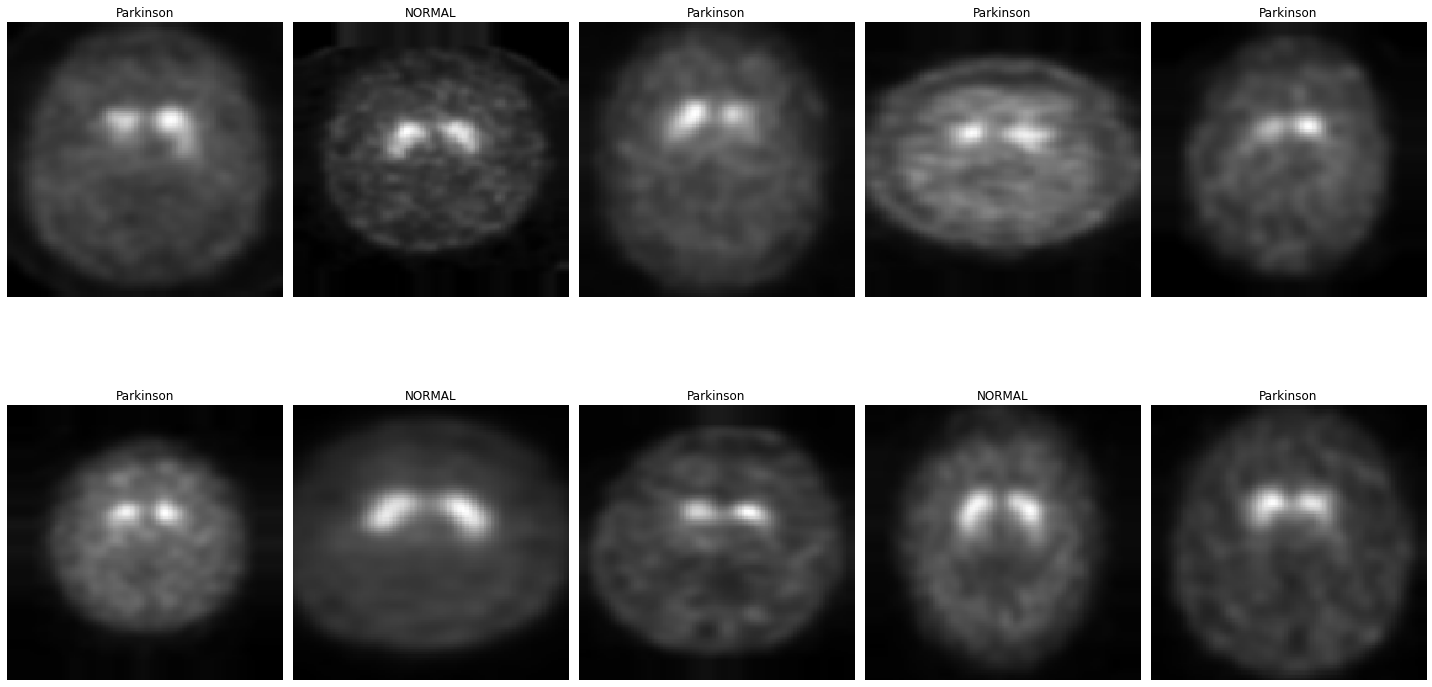

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'Parkinson'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# CNN Architecture

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

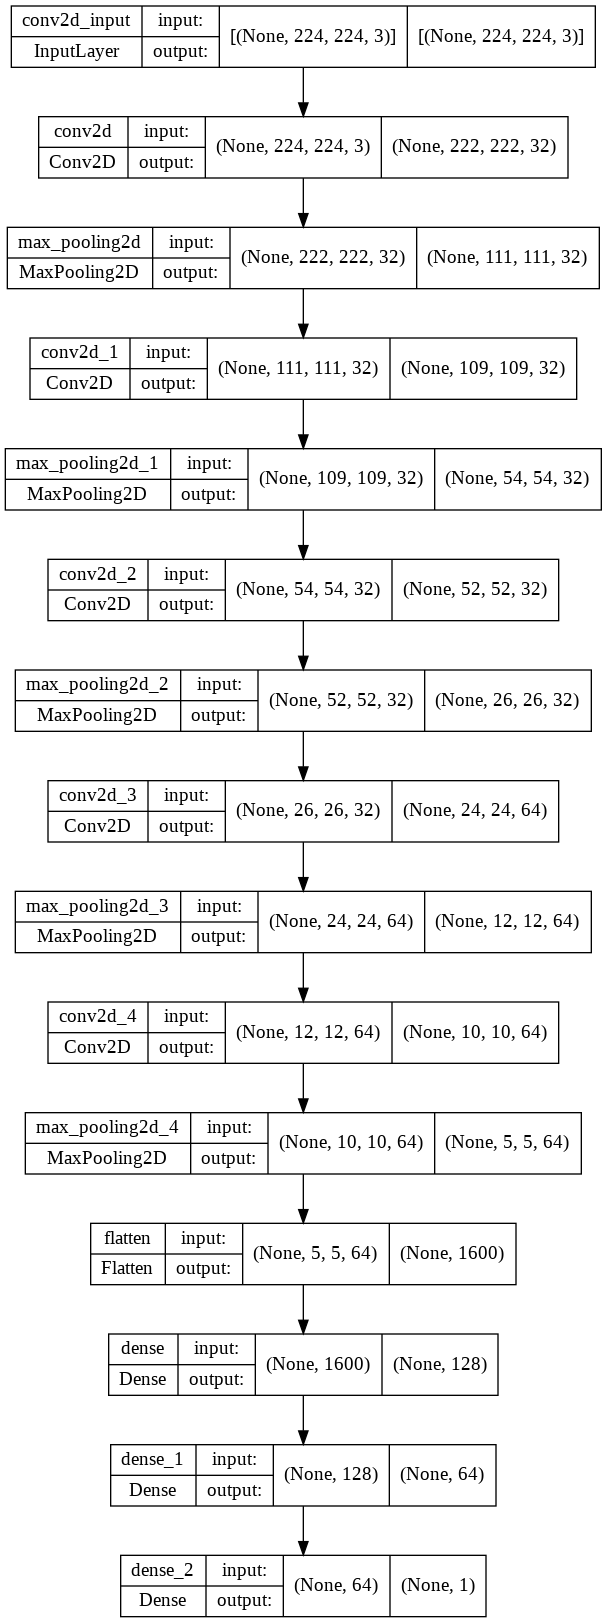

In [ ]:

plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

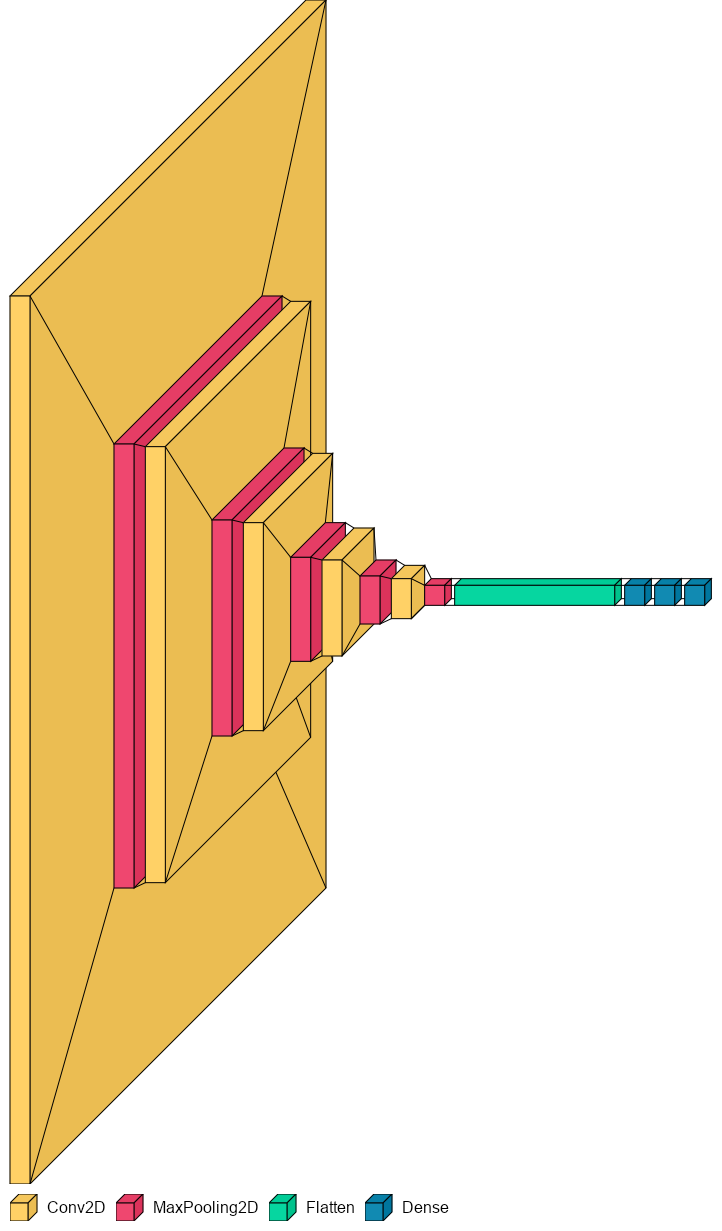

In [ ]:
visualkeras.layered_view(cnn, legend=True) # without custom font
from PIL import ImageFont
font = ImageFont.truetype("../arial.ttf", 16)
visualkeras.layered_view(cnn, legend=True, font=font) # selected font


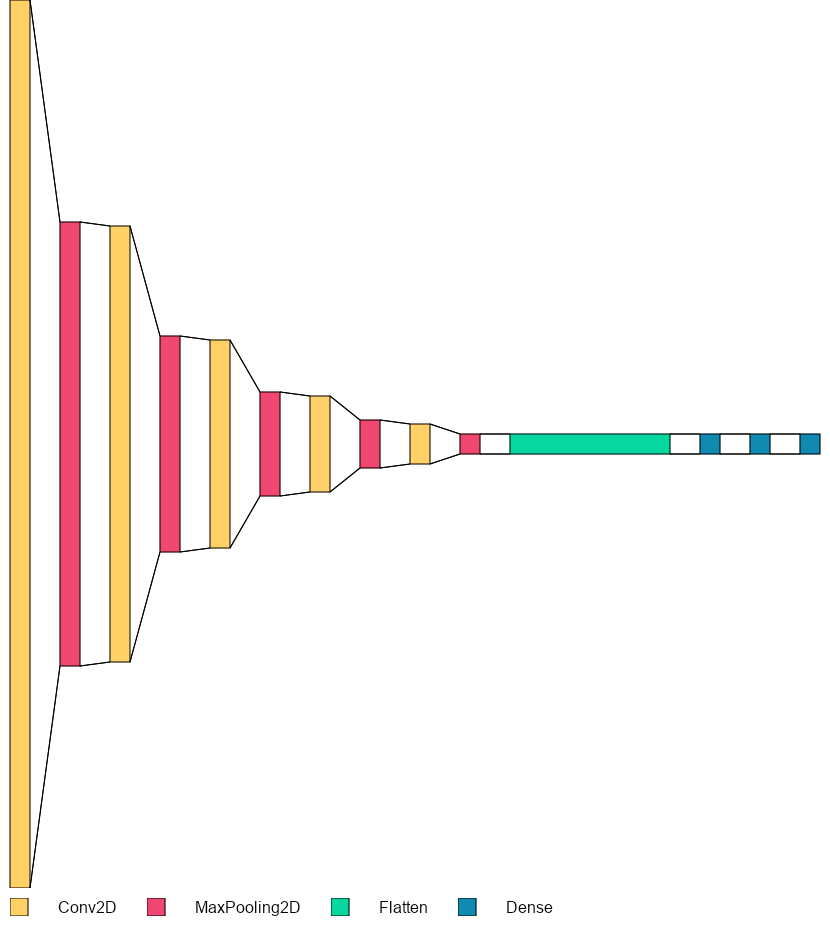

In [ ]:
visualkeras.layered_view(cnn, legend=True, font=font, draw_volume=False,spacing=30)


# Compil Model

In [ ]:
stop = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=2)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ stop, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train.classes),
                                        y =train.classes                                                    
                                    )

cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.5179640718562875, 1: 0.7455882352941177}


In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
32/32 [==============================] - 48s 1s/step - loss: 0.6694 - accuracy: 0.7613 - val_loss: 0.3616 - val_accuracy: 0.8871 - lr: 0.0010
Epoch 2/25
32/32 [==============================] - 6s 197ms/step - loss: 0.2572 - accuracy: 0.8757 - val_loss: 0.2762 - val_accuracy: 0.9516 - lr: 0.0010
Epoch 3/25
32/32 [==============================] - 6s 196ms/step - loss: 0.1506 - accuracy: 0.9408 - val_loss: 0.2031 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 4/25
32/32 [==============================] - 6s 198ms/step - loss: 0.1117 - accuracy: 0.9448 - val_loss: 0.2427 - val_accuracy: 0.9516 - lr: 0.0010
Epoch 5/25
32/32 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 0.9586
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
32/32 [==============================] - 7s 211ms/step - loss: 0.0959 - accuracy: 0.9586 - val_loss: 0.2273 - val_accuracy: 0.9677 - lr: 0.0010


In [ ]:
cnn.save("model.h5")

# Evaluation

In [ ]:
import keras
cnn = keras.models.load_model("model.h5")

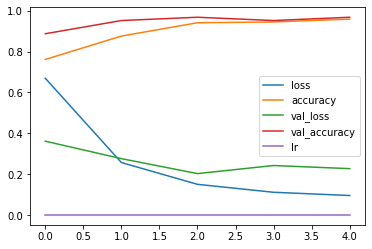

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
train_accu = cnn.evaluate(train)
print('The train accuracy is :',train_accu[1]*100, '%')

32/32 [==============================] - 76s 2s/step - loss: 0.0545 - accuracy: 0.9783
The train accuracy is : 97.83037304878235 %


In [ ]:
val_accu = cnn.evaluate(valid)
print('The validation accuracy is :',val_accu[1]*100, '%')

4/4 [==============================] - 10s 3s/step - loss: 0.2273 - accuracy: 0.9677
The validation accuracy is : 96.77419066429138 %


In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

5/5 [==============================] - 10s 2s/step - loss: 0.0674 - accuracy: 0.9692
The testing accuracy is : 96.92307710647583 %


In [ ]:
preds = cnn.predict(test,verbose=1)

5/5 [==============================] - 18s 2s/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [ ]:
print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','Parkinson']
 ))

              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95        22
   Parkinson       0.98      0.98      0.98        43

    accuracy                           0.97        65
   macro avg       0.97      0.97      0.97        65
weighted avg       0.97      0.97      0.97        65



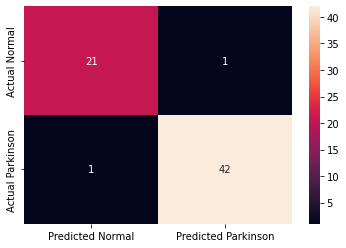

In [ ]:
confusion = confusion_matrix(test.classes, predictions, labels=[0, 1])
cm = pd.DataFrame(data=confusion,
                  index=["Actual Normal", "Actual Parkinson"],
                  columns=["Predicted Normal", "Predicted Parkinson"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
FP = confusion.sum(axis=0) - np.diag(confusion) 
FN = confusion.sum(axis=1) - np.diag(confusion) 
TP = np.diag(confusion) 
TN = confusion.sum() - (FP + FN + TP)
FP = FP.astype(float) 
FN = FN.astype(float) 
TP = TP.astype(float) 
TN = TN.astype(float)

In [ ]:
  import math 
  from sklearn.metrics import matthews_corrcoef
 
  from sklearn.metrics import roc_auc_score


  specificity = TN / (TN + FP)

  false_positive_rate = FP / (TN + FP)


  MCC =matthews_corrcoef(test.classes, predictions)

  Recall = TP / (FN + TP)

  NPV  = TN / (TN+FN)
  roc = roc_auc_score(test.classes, predictions)
 

  print("Specificity : {:.2%}".format(sum(specificity)/len(specificity)))
  print("--------------------------------------")

  print("False Positive Rate: {:.2%}".format(1 - sum(specificity)/2))
  print("--------------------------------------")

  print("Sensitivity: {:.2%}".format(metrics.recall_score(test.classes, predictions, average="macro")))
  print("--------------------------------------")

  print("Precision : {:.2%}".format(metrics.precision_score(test.classes, predictions, average="macro" )))
  print("--------------------------------------")

  print("Recall : {:.2}".format(sum(Recall)/2))
  print("--------------------------------------")
  print("F1-Score : {:.2%}".format(metrics.f1_score(test.classes, predictions,average="macro")))
  print("--------------------------------------")
  print("Area under ROC : {:.3}".format(roc ))
  print("--------------------------------------")
  print("Matthews Correlation Coefficient : {:.2}".format(MCC))
  print("--------------------------------------")
  print("Negative Predictive Value  : {:.2}".format(sum(NPV)/2))
  print("--------------------------------------")


Specificity : 96.56%
--------------------------------------
False Positive Rate: 3.44%
--------------------------------------
Sensitivity: 96.56%
--------------------------------------
Precision : 96.56%
--------------------------------------
Recall : 0.97
--------------------------------------
F1-Score : 96.56%
--------------------------------------
Area under ROC : 0.966
--------------------------------------
Matthews Correlation Coefficient : 0.93
--------------------------------------
Negative Predictive Value  : 0.97
--------------------------------------


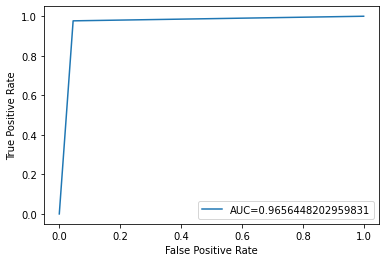

In [ ]:
fpr, tpr, _ = metrics.roc_curve(test.classes,  predictions)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(roc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(65, 224, 224, 3)
(65,)


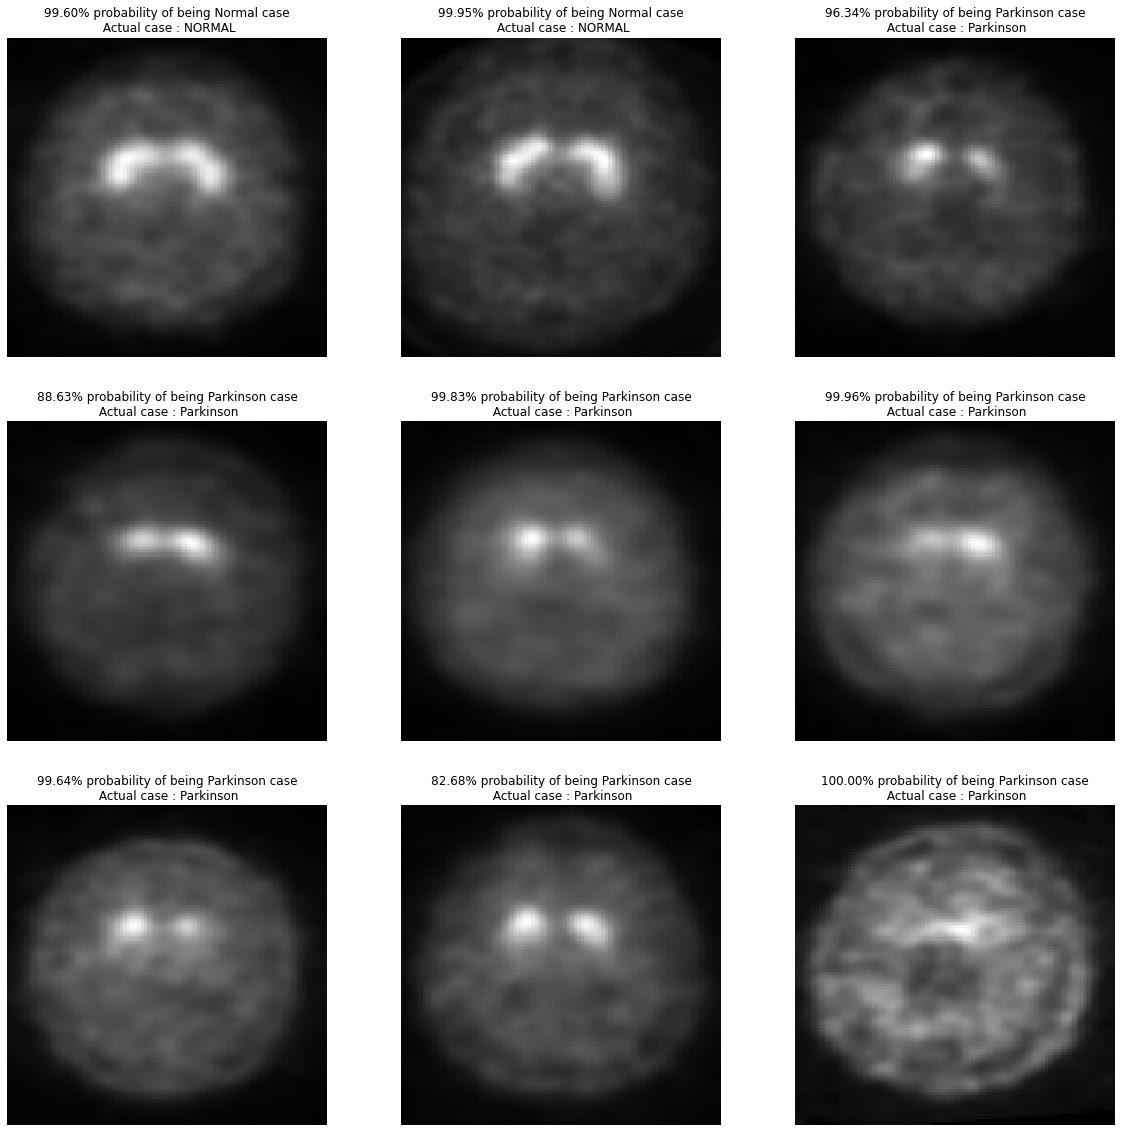

In [ ]:
import cv2
dic = {0:'NORMAL', 1:'Parkinson'}
plt.figure(figsize=(20,20))
for i in range(0+20, 9+20):
  plt.subplot(3, 3, (i-20)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Parkinson case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

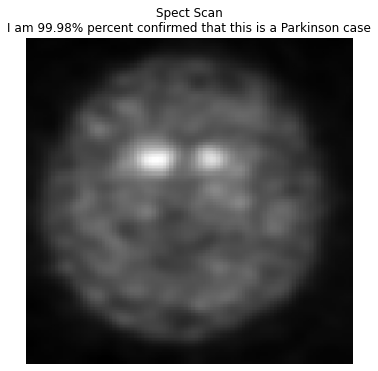

In [ ]:
hardik_path = '3001.png'
from tensorflow.keras.preprocessing import image
hardik_img = image.load_img(hardik_path, target_size=(224, 224,3),color_mode='rgb')
# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
#predict
hardik_preds= cnn.predict(pp_hardik_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Parkinson case'.format(hardik_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))
plt.title("Spect Scan\n"+out)  
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()

# Xai Methods

In [ ]:
import keras
model = keras.models.load_model("model.h5")

In [ ]:
hardik_path = 'output/test/Yes/3567-slice041.png'
from tensorflow.keras.preprocessing import image

import cv2

hardik_img = image.load_img(hardik_path, target_size=(224, 224,3),color_mode='rgb')
# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pd_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
pd_image = np.array(np.squeeze(pd_hardik_img), dtype=np.double)

#predict
pd_preds= model.predict(pd_hardik_img)


In [ ]:
hardik_path = 'output/test/No/3438-slice041.png'
from tensorflow.keras.preprocessing import image

import cv2

hardik_img = image.load_img(hardik_path, target_size=(224, 224,3),color_mode='rgb')
# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
normal_hardik_img = np.expand_dims(pp_hardik_img, axis=0)
normal_image = np.array(np.squeeze(normal_hardik_img), dtype=np.double)

#predict
normal_preds= model.predict(normal_hardik_img)


#LIME



In [ ]:
!pip install lime

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:

explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(pd_image, 
                                         model.predict, 
                                         top_labels=1, 
                                         hide_color=0,  num_samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

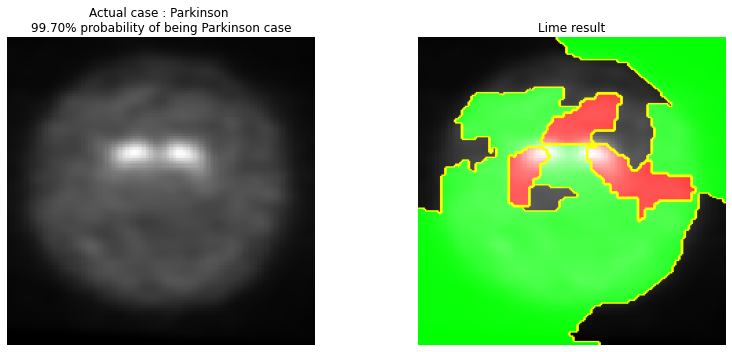

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            num_features=15, 
                                            hide_rest=False)
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.axis('off')
if pd_preds>= 0.5: 
    out = ('{:.2%} probability of being Parkinson case'.format(pd_preds[0][0]))
    
else: 
    out = ('{:.2%} probability of being Normal case'.format(1-pd_preds[0][0]))
plt.title("Actual case : Parkinson \n"+out)  
plt.imshow(pd_image)
ax = plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp , mask))

plt.axis('off')
plt.title('Lime result')
plt.tight_layout()

In [ ]:
explanation = explainer.explain_instance(normal_image, 
                                         model.predict, 
                                         top_labels=1, 
                                         hide_color=0,  num_samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

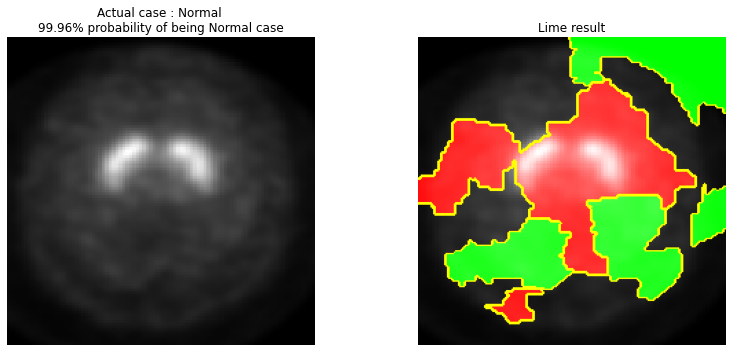

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            num_features=15, 
                                            hide_rest=False)
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.axis('off')
if normal_preds>= 0.5: 
    out = ('{:.2%} probability of being Parkinson case'.format(normal_preds[0][0]))
    
else: 
    out = ('{:.2%} probability of being Normal case'.format(1-normal_preds[0][0]))
plt.title("Actual case : Normal \n"+out)  
plt.imshow(normal_image)
ax = plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp , mask))

plt.axis('off')
plt.title('Lime result')
plt.tight_layout()

# Grad CAM

In [ ]:
import cv2

In [ ]:
from tensorflow.keras.models import Model

import tensorflow as tf
from keras import backend as K

def GradCam(model, img_array, layer_name, eps=1e-8):
  
    

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
		
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]

    grads = tape.gradient(loss, convOutputs)
    
    
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
   
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
   
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
	
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
 
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

In [ ]:
conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 ]
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 ]


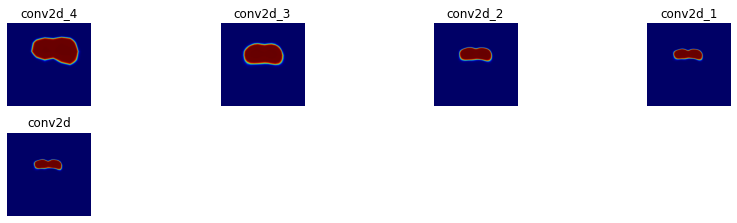

In [ ]:
## Visualizing Convolution layers
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model, np.expand_dims(pd_image, axis=0), layer)
  grad_cam_emphasized = superimpose(pd_image, grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

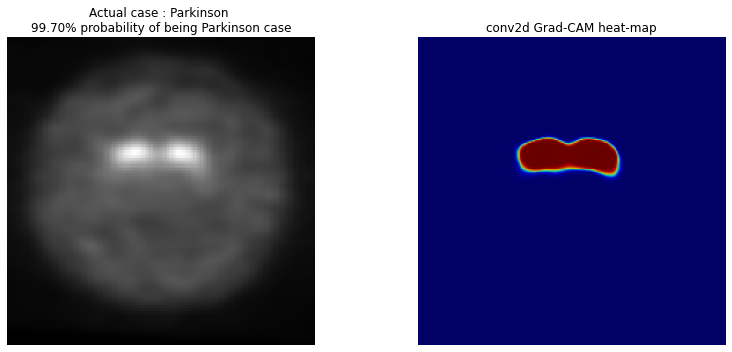

In [ ]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv2d

layer_name = 'conv2d'
grad_cam=GradCam(model,np.expand_dims(pd_image, axis=0),layer_name)
grad_cam_superimposed = superimpose(pd_image, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.axis('off')
if pd_preds>= 0.5: 
    out = ('{:.2%} probability of being Parkinson case'.format(pd_preds[0][0]))
    
else: 
    out = ('{:.2%} probability of being Normal case'.format(1-pd_preds[0][0]))
plt.title("Actual case : Parkinson \n"+out)  
plt.imshow(pd_image)
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('conv2d Grad-CAM heat-map')
plt.tight_layout()


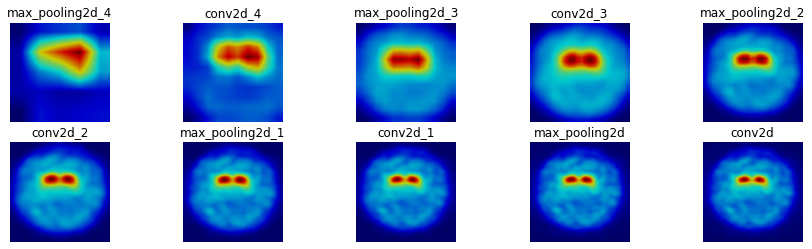

In [ ]:

# Visualizing Activation layers
plt.figure(figsize=(15, 15))
for i, layer in enumerate(activation_layers):
  grad_cam = GradCam(model, np.expand_dims(pd_image, axis=0), layer)
  grad_cam_emphasized = superimpose(pd_image, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(7, 5, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.show()

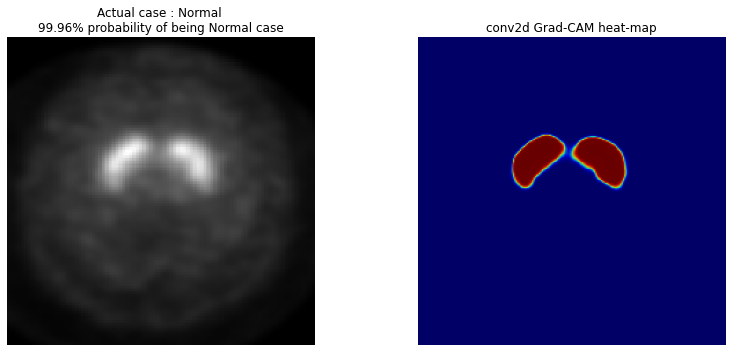

In [ ]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv2d

layer_name = 'conv2d'
grad_cam=GradCam(model,np.expand_dims(normal_image, axis=0),layer_name)
grad_cam_superimposed = superimpose(normal_image, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.axis('off')
if normal_preds>= 0.5: 
    out = ('{:.2%} probability of being Parkinson case'.format(normal_preds[0][0]))
    
else: 
    out = ('{:.2%} probability of being Normal case'.format(1-normal_preds[0][0]))
plt.title("Actual case : Normal \n"+out)  
plt.imshow(normal_image)
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('conv2d Grad-CAM heat-map')
plt.tight_layout()


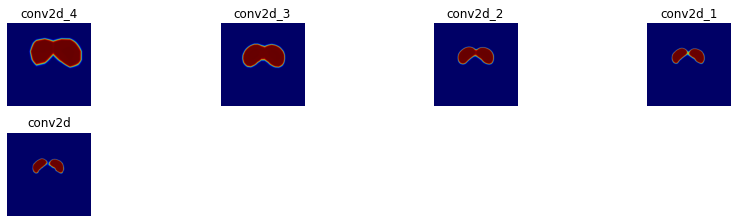

In [ ]:
## Visualizing Convolution layers
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model, np.expand_dims(normal_image, axis=0), layer)
  grad_cam_emphasized = superimpose(normal_image, grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

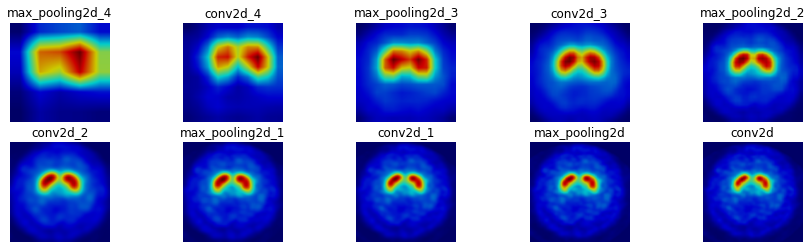

In [ ]:

# Visualizing Activation layers
plt.figure(figsize=(15, 15))
for i, layer in enumerate(activation_layers):
  grad_cam = GradCam(model, np.expand_dims(normal_image, axis=0), layer)
  grad_cam_emphasized = superimpose(normal_image, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(7, 5, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.show()

# Shap

In [ ]:
!pip install shap

In [ ]:
X, y = test.next()

In [ ]:
test.reset()
X_test=np.concatenate([test.next()[0] for i in range(test.__len__())])
y_test=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(X_test.shape)
print(y_test.shape)

(65, 224, 224, 3)
(65,)


In [ ]:
train.reset()
X_train=np.concatenate([train.next()[0] for i in range(train.__len__())])
y_train=np.concatenate([train.next()[1] for i in range(train.__len__())])
print(X_train.shape)
print(y_train.shape)

(507, 224, 224, 3)
(507,)


In [ ]:
type(X[[1]])

numpy.ndarray

In [ ]:
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import keras
model = keras.models.load_model("model.h5")

In [ ]:
classes = ['Normal','Parkinson']

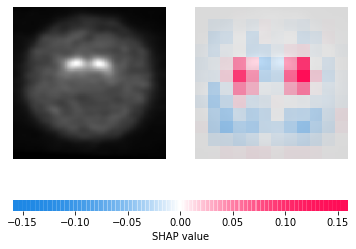

In [ ]:
import numpy as np
import shap

from tensorflow.keras.preprocessing import image

to_explain = pd_hardik_img


def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [x.copy()]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

# explain how the input to the 8th layer of the model explains the top  classes

e = shap.GradientExplainer((model.layers[8].input, model.layers[-1].output), map2layer(pd_hardik_img,8))
shap_values,indexes = e.shap_values(map2layer(to_explain/255, 8), ranked_outputs=2,
                                    output_rank_order='max')




shap.image_plot(shap_values, to_explain)

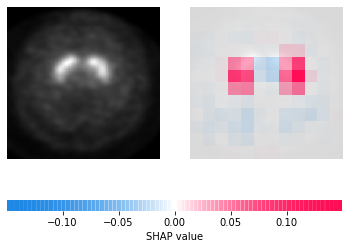

In [ ]:
import numpy as np
import shap

from tensorflow.keras.preprocessing import image

to_explain = normal_hardik_img


def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [x.copy()]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

# explain how the input to the 8th layer of the model explains the top  classes

e = shap.GradientExplainer((model.layers[8].input, model.layers[-1].output), map2layer(normal_hardik_img,8))
shap_values,indexes = e.shap_values(map2layer(to_explain/255, 8), ranked_outputs=2,
                                    output_rank_order='max')




shap.image_plot(shap_values, to_explain)

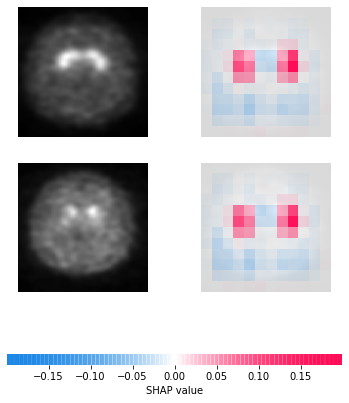

In [ ]:
import numpy as np
import shap

from tensorflow.keras.preprocessing import image




to_explain = X_test[[20,50]]





def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [x.copy()]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

# explain how the input to the 8th layer of the model explains the top  classes

e = shap.GradientExplainer((model.layers[8].input, model.layers[-1].output), map2layer(X_test.copy(),8))
shap_values,indexes = e.shap_values(map2layer(to_explain/255, 8), ranked_outputs=1)


# plot the explanations
shap.image_plot(shap_values, to_explain)